## CT5133 / CT5145 Deep Learning (/Online) 2023-2024 (Part 2, James McDermott)

## Assignment 2

* Student ID(s): 23104534
* Student name(s): Vikrant Singh Jamwal

In this assignment, we'll create an image classifier, inspect the embeddings it produces, try out different hyperparameters, and compare to a pretrained model.

### Due date

As announced on Canvas.

### Weighting

20% of the module.

### Tasks

1. Load and preprocess the `CIFAR-10` dataset using the supplied code.
2. Create a small convolutional model for classifying this dataset. Use a final `Dense(10)` layer for classification. Before that, use a `Dense(z)` layer, where `z` is a hyperparameter with value `z=2` for now.
3. Train the model and report performance. Ensure the training log is visible in the notebook. By looking at the training loss and validation loss, decide how many epochs are needed.
4. Visualise the output of the penultimate `Dense(z)` layer, on a subset of test data. One approach could use the supplied `visualise_embedding` function.
5. Repeat Steps 3-4 for some variants of the network: try `z=2` and `z=10`, and try some changes in architecture such as using different kernel parameters, more or different layers, or a different optimiser. And/or try using different fractions of the data during training.
6. Load a pretrained model, freeze it, discard its classification head, and add a new classification head suitable for the task. Again repeat Steps 3-4 for this network (choosing a suitable layer for visualisation, which can again be a `Dense(2)`, if you like). (You don't need to repeat Step 5 for this network.) Note: if the pretrained model does not like the CIFAR-10 image size (32x32), code for resizing images is supplied.
7. For each model you created, and for the pretrained model, comment (using Markdown cells in the notebook) on the differences in the embedding: how many dimensions are there, and why? Ignoring classes, what distribution of data do you observe and why? Now focussing on classes, what do you observe? Which embeddings are better? Relate this to performance of the classifier in each case. This part must be written in your own words.


### Grading

1. 0 marks.
2. 3 marks for a conv model with no conceptual errors, with a Dense(2) layer. Partial marks: 1 mark for any model that compiles ok.
3. 2 marks for a successful training log, with epochs chosen based on correct reasoning with the loss values. Partial marks: 1 mark for any training log.
4. 0 marks.
5. 5 marks for trying multiple sensible variations, well-organised. Partial marks: 2 marks if only 1-2 variations, or they are not sensible (eg, they reveal a misunderstanding of what different layers do). 1 mark for some attempt at variation leading to a different training log, versus (3).
6. 4 marks. 1 for loading and freezing and discarding head. 2 for appropriate design of classification head and 1 for training. 1 for visualisation.
7. 6 marks. Full marks for answers to all, demonstrating understanding of all issues. Guideline: 1 sentence for each answer, for each model, is likely sufficient. Partial marks: 3 marks for giving observations without understanding of what would be desirable properties in embeddings, or relation to classifier performance.

Marks will be subtracted for issues such as existing code used without attribution, or generative AI used without attribution.

Total: 20 marks



### Some rules

* **Groups**: students may work solo or in a group of two. A student may not work together in a group with any student they have previously worked on a group project with, in this module or any other in the MSc programme. **Groups must be notified to the lecturer in writing before beginning work and at least 1 week before submission.** If working in a group, both students must submit and both submissions must be identical. If working in a group, both students may be asked to explain any aspect of the code in interview (see below), therefore working independently on separate components is not recommended. Any emails concerning the project should be cc-ed to the other group member.

* **Libraries**: code can be written in Keras using the Tensorflow or PyTorch backend, or in PyTorch itself.

* **Generative AI** can be used to generate the code for this assignment. Every piece of generated material must be individually and clearly marked and attributed to a specific model, with a URL linking to the model, and must include the prompt(s) used, and a comment on why you chose to use Generative AI for this particular task or problem. The student is still required to understand all details of their own submission. Low grades will be awarded where it is clear generative AI has been used without attribution. When commenting on the embeddings, you must look at the embedding with your own eyes and comment on it yourself, in your own words.

* **Plagiarism**: students may discuss the assignment together, but you may not look at another student or group's work or allow other students to view yours (other than within a group). You may use snippets of code from the internet, **if you provide a citation with URL for each specific part**. A set of references at the bottom of the notebook is not sufficient.

* **Submission**: after completing your work in this Jupyter notebook, submit your notebook on Canvas in `.ipynb` format.

* **Interviews**: a number of students may be selected for interview, post-submission. The selection will depend on submissions, and random chance may be used also. Interviews will be held in-person (CT5133) or online (CT5145). Interviews will last approximately 10 minutes. The purpose of interviews will be to assess students' understanding of their own submission.

### Some code is provided:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

!pip install umap-learn
import umap
import keras

from keras.layers import Resizing
from keras.datasets import cifar10
from keras.utils import to_categorical, set_random_seed

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 3.9 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=cea9870aa340e2bb803d15d37bd56c9bbd438dd29c8f7995e14c038d5aa2df3c
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn


In [2]:
# remove this cell before posting
from keras.applications import MobileNetV2
from keras.models import Model, Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Input, BatchNormalization, Activation, Dropout

In [3]:
# https://keras.io/examples/keras_recipes/reproducibility_recipes/

# Set the seed using keras.utils.set_random_seed. This will set:
# 1) `numpy` seed
# 2) backend random seed
# 3) `python` random seed
set_random_seed(0)

In [4]:
def subsample(X, y=None, p=0.1):
    # work with a fraction of the data
    n_samples = X.shape[0]
    subsample_size = int(n_samples * p)
    idxs = np.random.choice(n_samples, subsample_size, replace=False)
    if y is None:
        return X[idxs]
    else:
        return X[idxs], y[idxs]

def visualise_embedding(X, y=None, p_subsample=None):
    """
    Visualise an embedding X as a scatterplot.

    Optionally visualise class labels y at the same time as colours.

    If X has >2 dimensions, use UMAP to reduce to 2.

    User can supply eg subsample=0.01, to show a small fraction of the data.
    """
    n_samples, n_features = X.shape

    # check X and y shapes compatible
    if y is not None:
        if n_samples != y.shape[0]:
            raise ValueError(f"X and y have incompatible shapes {X.shape} and {y.shape}")

        if len(y.shape) == 2:
            # these are probably one-hot encoded, so convert to integer
            y = np.argmax(y, axis=1)

    # work with only a fraction of the data
    if p_subsample is not None:
        if y is None:
            X = subsample(X, p_subsample)
        else:
            X, y = subsample(X, y, p_subsample)

    # ensure we have 2 dimensions, using UMAP for dim reduction if needed
    if n_features > 2:
        import umap # pip install umap-learn
        reducer = umap.UMAP()
        X = StandardScaler().fit_transform(X) # need all dimensions to be on approx same scale
        X = reducer.fit_transform(X) # UMAP reduce to 2D

    # Visualization
    colors = plt.get_cmap('tab10')  # Get a color map with 10 distinct colors

    plt.figure(figsize=(10, 8))
    for i in range(10): # for 10 classes in CIFAR-10
        indices = np.where(y == i)
        plt.scatter(X[indices, 0], X[indices, 1], label=f'Class {i}', color=colors(i))

    # reflect the dim reduction in axis labels if needed
    if n_features == 2:
        axis0_lab = "z0"
        axis1_lab = "z1"
    else:
        axis0_lab = "UMAP0"
        axis1_lab = "UMAP1"

    plt.legend()
    plt.xlabel(axis0_lab)
    plt.ylabel(axis1_lab)
    plt.show()

In [5]:
# Load CIFAR-10 data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train.shape

170498071/170498071 [==============================] - 13s 0us/step


(50000, 1)

In [6]:
# keep only a small amount of the training data for fast prototyping
# later, we could train on all data, by commenting out this line
x_train, y_train = subsample(x_train, y_train, 0.2)

# convert image data to float16 to save some memory
x_train = x_train.astype('float16')
x_test = x_test.astype('float16')

# normalise X
x_train, x_test = x_train / 255.0, x_test / 255.0
# one-hot encode y
y_train, y_test = to_categorical(y_train, 10), to_categorical(y_test, 10)
y_train.shape

(10000, 10)

In [7]:
# some pretrained models require a specific image *size*.
# if needed, we can use code like this to make a resized version of the images

resizing_layer = Resizing(96, 96) # a resizing layer can work on its own, doesn't have to be part of a model
x_train_96px = resizing_layer(x_train)
x_test_96px = resizing_layer(x_test)

Per Karpathy: look at your data! And make sure to look at it immediately before training, after any preprocessing, in case of preprocessing bugs. You want to see exactly what the network will see. (Unfortunately we have to give a `float32` to keep Matplotlib `imshow` happy.)

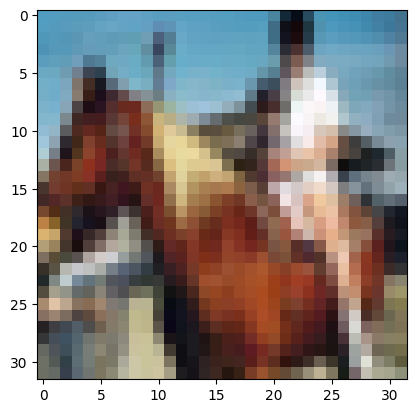

In [8]:
plt.imshow(x_train[0].astype('float32'));

# Task 2 : Create a small CNN model with "z" as hyperparameter

* Created a small convolutional neural network function.
* Three convolutional layers, each followed by layers of Max pooling to down-sample with a window/pool size of (2,2).
* Used dropout of 0.3 (romoving 30% of the training data randomly to avoid overfitting by preventing the data to fit too closely.)
* Used two dense layer, first penultimate dense layer with z as the hyperparameter and the final one for classification with z = number of classes (10).
* Compiled the model with Adam optimizer.
* Hyperparameters:
  * <code>z</code>- To select the number of neurons for the penultimate dense layer.
  * <code>input_shape</code>- Shape of the input, For CIFAR-10 it is (32,32,3).
  * <code>classes</code>- Number of classes in the dataset, For CIFAR-10 it is 10.

In [9]:
# Defining a cnn model function


def cnn_model(z, input_shape, classes):

    # To create stacking of sequential layers.
    model = Sequential()

    # Conv Layer 1, activation is "relu", filters are 32 and kernel size is (3,3)
    model.add(Conv2D(32 , (3,3), input_shape = input_shape, activation = "relu"))
    model.add(MaxPooling2D((2,2)))


    # Conv Layer 2, activation is "relu", filters are 64 and kernel size is (3,3)
    model.add(Conv2D(64, (3,3), activation = "relu"))
    model.add(MaxPooling2D((2,2)))

    # Conv Layer 3, activation is "relu", filters are 32 and kernel size is (3,3)
    model.add(Conv2D(32, (3,3), activation = "relu"))
    model.add(MaxPooling2D((2,2)))

    # Dropout 0.3 fraction of training data to prevent overfitting.
    model.add(Dropout (0.3))
    # Flattening the multi dimensions to single dimension in order to transition from convolutional to dense layer.
    model.add(Flatten())

    # Penultimate dense layer with hyperparameter z as number of neurons.
    model.add(Dense(z, name = "p_dense_layer", activation ="relu"))
    # Final classification head or dense layer with 10 (number of classes) neurons.
    model.add(Dense(classes, activation = "softmax"))

    # Compiling the model with "adam" optimizer and loss as categorical cross entropy
    model.compile(loss= "categorical_crossentropy", optimizer ="adam", metrics = ["accuracy"])

    return model

In [23]:
z = 2 # Intialising z = 2
input_shape = (32,32,3) # Shape of the training input dataset
classes = y_train.shape[1] # Number of classes, as one hop encoding will create columns for each class, hence number of columns = number of classes

model_z2 = cnn_model(z, input_shape, classes) # Creating a z=2 model instance

In [24]:
# Viewing the summary of the model instance
model_z2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 4, 4, 32)          18464     
                                                                 
 dropout_1 (Dropout)         (None, 4, 4, 32)         

# Task 3: Training, Evaluating and Logging

Trained the model with 60 epochs to figure out the number of epochs required for an efficient model.

In [25]:
# Initialising hyperparameters.
batch_size = 50
epochs = 60

# Fitiing the model on the subset of training data.
training_log_z2 = model_z2.fit(x_train, y_train, batch_size = batch_size, epochs = epochs, validation_split = 0.1)

Epoch 1/60
180/180 [==============================] - 2s 6ms/step - loss: 2.2870 - accuracy: 0.1113 - val_loss: 2.2508 - val_accuracy: 0.1230
Epoch 2/60
180/180 [==============================] - 1s 5ms/step - loss: 2.2124 - accuracy: 0.1353 - val_loss: 2.1580 - val_accuracy: 0.1280
Epoch 3/60
180/180 [==============================] - 1s 5ms/step - loss: 2.1220 - accuracy: 0.1564 - val_loss: 2.0961 - val_accuracy: 0.1570
Epoch 4/60
180/180 [==============================] - 1s 6ms/step - loss: 2.0729 - accuracy: 0.1887 - val_loss: 2.0212 - val_accuracy: 0.2020
Epoch 5/60
180/180 [==============================] - 1s 7ms/step - loss: 2.0223 - accuracy: 0.1989 - val_loss: 1.9854 - val_accuracy: 0.1780
Epoch 6/60
180/180 [==============================] - 1s 5ms/step - loss: 1.9794 - accuracy: 0.2054 - val_loss: 1.9558 - val_accuracy: 0.1970
Epoch 7/60
180/180 [==============================] - 1s 5ms/step - loss: 1.9549 - accuracy: 0.2101 - val_loss: 1.9360 - val_accuracy: 0.2210
Epoch 

## Plotting the training and validation accuracy curve

In [26]:
# Created a function for plotting loss and accuracy curve with epochs.

def history_plot(log):

    # subplot 1 for loss-epoch curve
    plt.subplot(2,1,1)
    plt.plot(log.history["loss"], label="train_loss")
    plt.plot(log.history["val_loss"], label = "val_loss")
    plt.ylabel("Loss")
    plt.legend()

    # subplot 2 for accuracy-epoch curve
    plt.subplot(2,1,2)
    plt.plot(log.history["accuracy"], label ="train_accuracy")
    plt.plot(log.history["val_accuracy"], label = "val_accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epochs")

    plt.legend()
    plt.show();

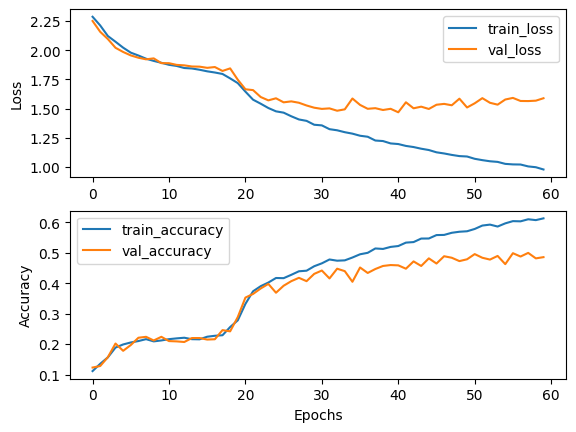

In [27]:
history_plot(training_log_z2)

In [29]:
test_eval = model_z2.evaluate(x_test, y_test)
print(f"Loss: {test_eval[0]} \nAccuracy: {test_eval[1]*100:.2f}%")

313/313 [==============================] - 1s 3ms/step - loss: 1.5965 - accuracy: 0.4617
Loss: 1.5964831113815308 
Accuracy: 46.17%


# Observations (Selected epochs = 35)

* From the loss curve and accuracy curve, we can visualise that after 30 epochs, model started to overfit as training accuracy increased but there was no significant improvement in the validation accuracy as compared to the training accuracy.

* Hence, epochs can be taken as <code>35</code> with a small buffer of 5 epochs to avoid early stopping.

# Task 4: Visualising the embedding of the penultimate dense layer

Here, the output of penultimate dense layer is collected and visualised using the given function.

313/313 [==============================] - 1s 3ms/step


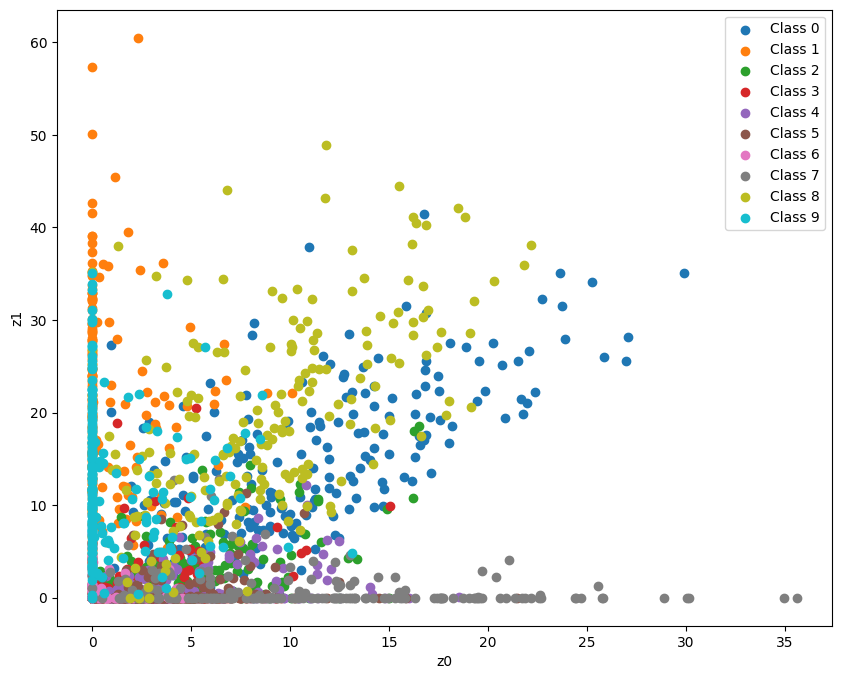

In [31]:
# Gathering the output of the dense layer

dense_z2_model = Model(inputs = model_z2.input, outputs = model_z2.get_layer("p_dense_layer").output)
dense_z2_output = dense_z2_model.predict(x_test)


# Creating visualisation from the given function with 20% sample of test data

visualise_embedding(dense_z2_output, y_test, 0.2)

# Task 5: Varients of the model


## Varient 1: <code><i>model_z2</i></code>

  Updates:
  * z = 2
  * Complete CIFAR-10 dataset is trained

In [34]:
# Loading complete dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Converting type to float16
x_train = x_train.astype('float16')
x_test = x_test.astype('float16')

# normalise X
x_train, x_test = x_train / 255.0, x_test / 255.0
# one-hot encode y
y_train, y_test = to_categorical(y_train, 10), to_categorical(y_test, 10)

In [35]:
# Initialising batch size, epochs and z value
batch = 50
epochs = 35
z=2

# Initialising the model instance
model_z2 = cnn_model(z, input_shape, classes)

# Training the model and recording the logs
training_log_v1 = model_z2.fit(x_train, y_train, batch_size = batch, epochs = epochs, validation_split = 0.1)

Epoch 1/35
900/900 [==============================] - 6s 5ms/step - loss: 2.1331 - accuracy: 0.1878 - val_loss: 1.9621 - val_accuracy: 0.2404
Epoch 2/35
900/900 [==============================] - 6s 7ms/step - loss: 1.8724 - accuracy: 0.2751 - val_loss: 1.7640 - val_accuracy: 0.3272
Epoch 3/35
900/900 [==============================] - 4s 5ms/step - loss: 1.7204 - accuracy: 0.3442 - val_loss: 1.6745 - val_accuracy: 0.3520
Epoch 4/35
900/900 [==============================] - 5s 5ms/step - loss: 1.6157 - accuracy: 0.3757 - val_loss: 1.5916 - val_accuracy: 0.3748
Epoch 5/35
900/900 [==============================] - 5s 5ms/step - loss: 1.5415 - accuracy: 0.3959 - val_loss: 1.5143 - val_accuracy: 0.4002
Epoch 6/35
900/900 [==============================] - 4s 5ms/step - loss: 1.4973 - accuracy: 0.4130 - val_loss: 1.4471 - val_accuracy: 0.4334
Epoch 7/35
900/900 [==============================] - 5s 6ms/step - loss: 1.4552 - accuracy: 0.4256 - val_loss: 1.4207 - val_accuracy: 0.4412
Epoch 

### Plotting loss and accuracy curve

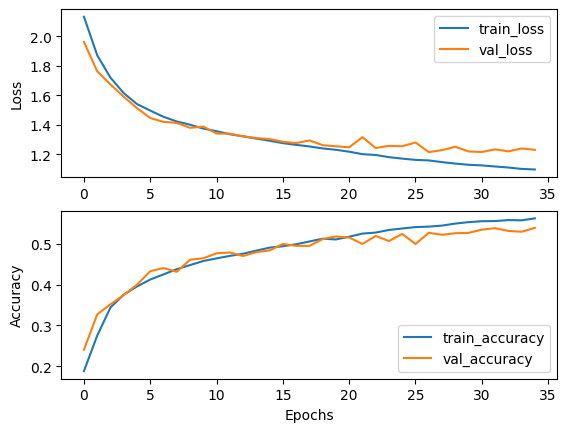

In [36]:
# Plotiing the curves with the above created function
history_plot(training_log_v1)

### Evaluating model

In [37]:
test_eval = model_z2.evaluate(x_test, y_test)
print(f"Loss: {test_eval[0]} \nAccuracy: {test_eval[1]*100:.2f}%")

313/313 [==============================] - 2s 4ms/step - loss: 1.2485 - accuracy: 0.5338
Loss: 1.2485369443893433 
Accuracy: 53.38%


### Visualising the embeddeings

313/313 [==============================] - 1s 3ms/step


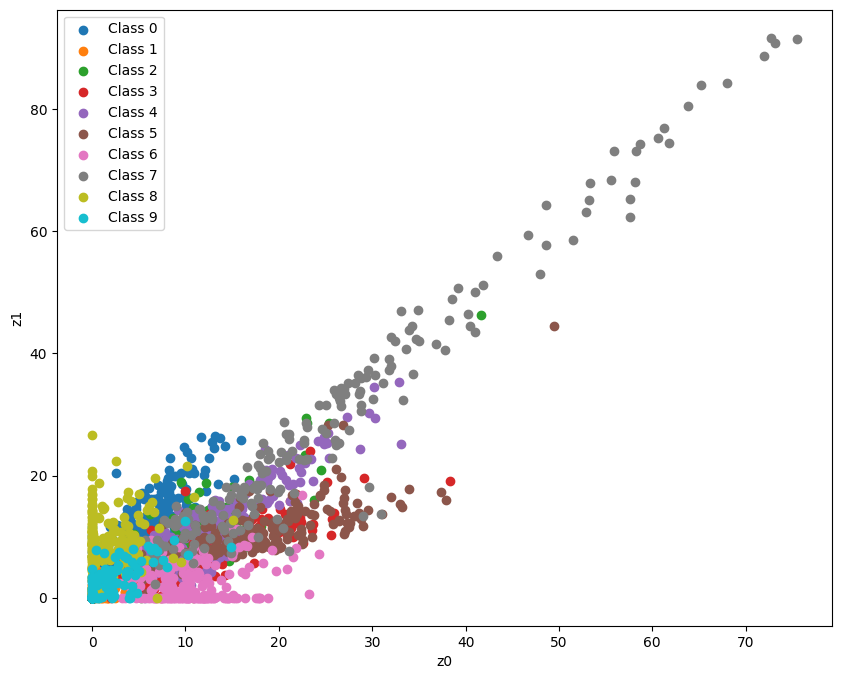

In [38]:
# Gathering the output of the dense layer

dense_z2_model = Model(inputs = model_z2.input, outputs = model_z2.get_layer("p_dense_layer").output)
dense_z2_output = dense_z2_model.predict(x_test)


# Creating visualisation from the given function with 20% sample of test data

visualise_embedding(dense_z2_output, y_test, 0.2)

## Results

* As Z = 2, the dimension reduced to 2 (z0 and z1) for the embedding of this penultimate dense layer.
* As "relu" is used as an activation function, hence the data is distributed in the scatter plot and all the negative values are mapped to 0.
* We can still visualise classes being differentiated, but the overlapping is still significantly present which affected the accuaracy of the model.

## Varient 2: <code><i>model_z10</i></code>

Updates:
* z = 10, as we saw the penultimate dense layer dimension is 2 in the previous model making it difficult to classify all the classes distinguishly as low-dimensions may not capture any complex relations and may cause information loss.

In [39]:
z=10 # z is updated to 10 from 2
batch = 100
epochs = 35

model_z10 = cnn_model(z, input_shape, classes)
training_log_v2 = model_z10.fit(x_train, y_train, batch_size = batch, epochs = epochs, validation_split = 0.2)

Epoch 1/35
400/400 [==============================] - 4s 7ms/step - loss: 1.9389 - accuracy: 0.2701 - val_loss: 1.7046 - val_accuracy: 0.3830
Epoch 2/35
400/400 [==============================] - 3s 6ms/step - loss: 1.5777 - accuracy: 0.4196 - val_loss: 1.4129 - val_accuracy: 0.4866
Epoch 3/35
400/400 [==============================] - 4s 9ms/step - loss: 1.4069 - accuracy: 0.4896 - val_loss: 1.3168 - val_accuracy: 0.5183
Epoch 4/35
400/400 [==============================] - 3s 9ms/step - loss: 1.3055 - accuracy: 0.5245 - val_loss: 1.2417 - val_accuracy: 0.5565
Epoch 5/35
400/400 [==============================] - 3s 8ms/step - loss: 1.2523 - accuracy: 0.5490 - val_loss: 1.1745 - val_accuracy: 0.5834
Epoch 6/35
400/400 [==============================] - 5s 13ms/step - loss: 1.1985 - accuracy: 0.5719 - val_loss: 1.1463 - val_accuracy: 0.5942
Epoch 7/35
400/400 [==============================] - 3s 8ms/step - loss: 1.1530 - accuracy: 0.5886 - val_loss: 1.0898 - val_accuracy: 0.6123
Epoch

### Plotting loss-epoch curve

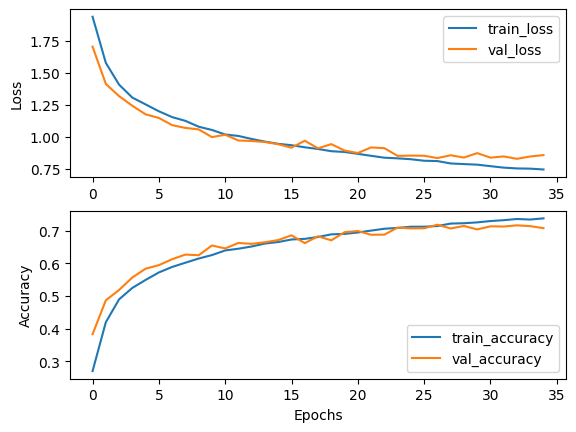

In [40]:
history_plot(training_log_v2)

### Evaluating Model

In [41]:
test_eval = model_z10.evaluate(x_test, y_test)
print(f"Loss: {test_eval[0]} \nAccuracy: {test_eval[1]*100:.2f}%")

313/313 [==============================] - 1s 3ms/step - loss: 0.8540 - accuracy: 0.7092
Loss: 0.8540410399436951 
Accuracy: 70.92%


### Visualising the embeddings

313/313 [==============================] - 1s 3ms/step


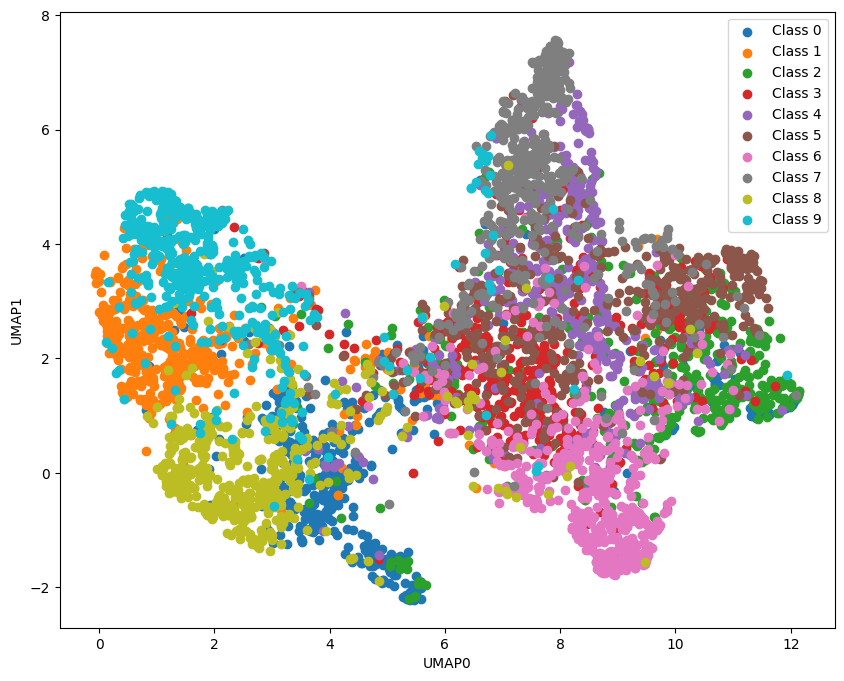

In [43]:
# Gathering the output of the dense layer

dense_z10_model = Model(inputs = model_z10.input, outputs = model_z10.get_layer("p_dense_layer").output)
dense_z10_output = dense_z10_model.predict(x_test)


# Creating visualisation from the given function with 50% sample of test data

visualise_embedding(dense_z10_output, y_test, 0.5)

## Results

* As z=10, the dimensions of the penultimate layer embedding is 10.
* Data is distibuted in a starfish shape, where ideally each leg represents a class.
* Due to the dimension increment, the model is well able to distinguish between classes and this can be seen distinct in the embedding visualisation above. Although z=10 is better than z=2, we still can observe overlappings, which lead to inaccuracies.

## Varient 3: <code><i>model_k4</i></code>

Updates:
* kernel size = (4,4). Increasing the kernel size to capture more complex patterns.
* Filters of last convolutional layer increased to 128. To capture more complex relationships.

### Updated Model

In [44]:
# Defining a cnn model function


def cnn_model_complex(z, input_shape, classes):

    # To create stacking of sequential layers.
    model = Sequential()

    # Conv Layer 1, activation is "relu", filters are 32 and kernel size is (4,4)
    model.add(Conv2D(32 , (4,4), input_shape = input_shape, activation = "relu"))
    model.add(MaxPooling2D((2,2)))

    # Conv Layer 2, activation is "relu", filters are 64 and kernel size is (4,4)
    model.add(Conv2D(64, (4,4), activation = "relu"))
    model.add(MaxPooling2D((2,2)))

    # Conv Layer 3, activation is "relu", filters are 128 and kernel size is (4,4)
    model.add(Conv2D(128, (4,4), activation = "relu"))
    model.add(MaxPooling2D((2,2)))

    # Dropout 0.3 fraction of training data to prevent overfitting.
    model.add(Dropout (0.3))
    # Flattening the multi dimensions to single dimension in order to transition from convolutional to dense layer.
    model.add(Flatten())

    # Penultimate dense layer with hyperparameter z as number of neurons.
    model.add(Dense(z, name = "p_dense_layer", activation ="relu"))
    # Final classification head or dense layer with 10 (number of classes) neurons.
    model.add(Dense(classes, activation = "softmax"))

    # Compiling the model with "adam" optimizer and loss as categorical cross entropy
    model.compile(loss= "categorical_crossentropy", optimizer ="adam", metrics = ["accuracy"])

    return model

In [45]:
z=10
batch = 100
epochs = 35
model_v3 = cnn_model_complex(z, input_shape, classes)
training_log_v3 = model_v3.fit(x_train, y_train, batch_size = batch, epochs = epochs, validation_split = 0.2)

Epoch 1/35
400/400 [==============================] - 5s 7ms/step - loss: 1.9548 - accuracy: 0.2578 - val_loss: 1.7273 - val_accuracy: 0.3599
Epoch 2/35
400/400 [==============================] - 4s 9ms/step - loss: 1.6259 - accuracy: 0.4037 - val_loss: 1.4940 - val_accuracy: 0.4528
Epoch 3/35
400/400 [==============================] - 3s 8ms/step - loss: 1.4621 - accuracy: 0.4643 - val_loss: 1.3661 - val_accuracy: 0.5042
Epoch 4/35
400/400 [==============================] - 3s 8ms/step - loss: 1.3597 - accuracy: 0.5058 - val_loss: 1.2805 - val_accuracy: 0.5371
Epoch 5/35
400/400 [==============================] - 3s 9ms/step - loss: 1.2925 - accuracy: 0.5324 - val_loss: 1.2376 - val_accuracy: 0.5521
Epoch 6/35
400/400 [==============================] - 5s 12ms/step - loss: 1.2292 - accuracy: 0.5584 - val_loss: 1.2297 - val_accuracy: 0.5698
Epoch 7/35
400/400 [==============================] - 3s 6ms/step - loss: 1.1833 - accuracy: 0.5746 - val_loss: 1.1508 - val_accuracy: 0.5929
Epoch

### Plotting loss-epoch curve

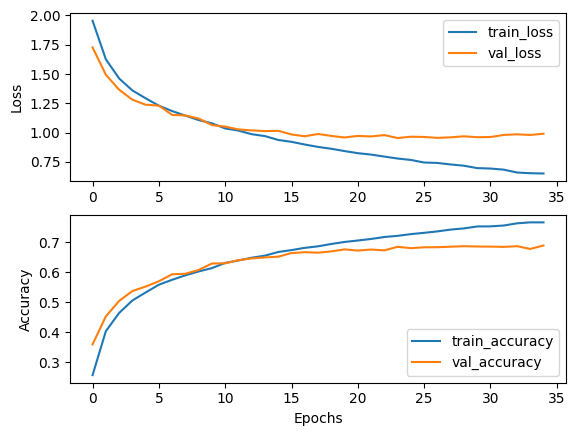

In [46]:
history_plot(training_log_v3)

### Evaluating Model

In [47]:
test_eval = model_v3.evaluate(x_test, y_test)
print(f"Loss: {test_eval[0]} \nAccuracy: {test_eval[1]*100:.2f}%")

313/313 [==============================] - 1s 3ms/step - loss: 1.0052 - accuracy: 0.6841
Loss: 1.0052028894424438 
Accuracy: 68.41%


### Visualising the embeddings

313/313 [==============================] - 1s 2ms/step


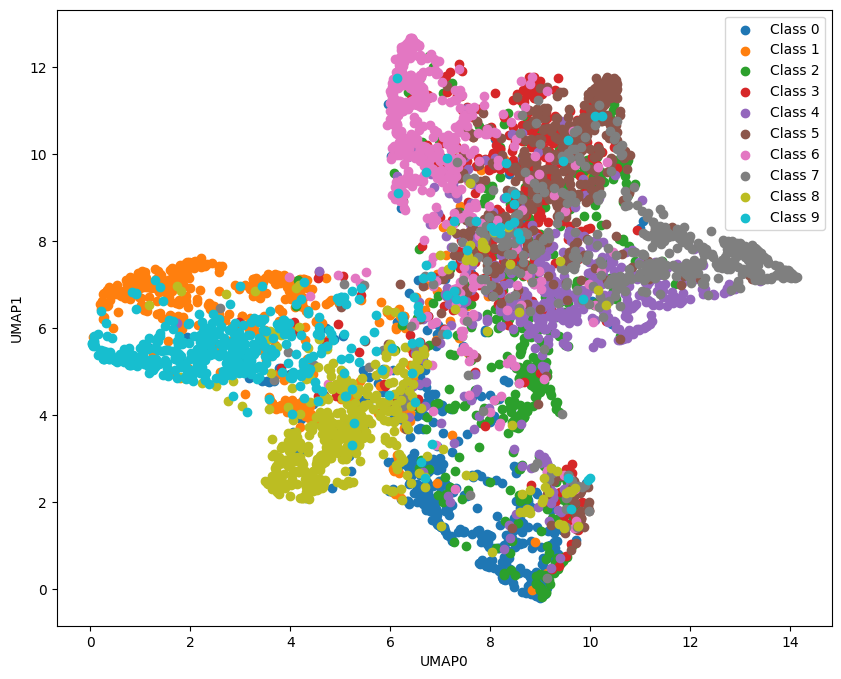

In [48]:
# Gathering the output of the dense layer

dense_v3_model = Model(inputs = model_v3.input, outputs = model_v3.get_layer("p_dense_layer").output)
dense_v3_output = dense_v3_model.predict(x_test)


# Creating visualisation from the given function with 50% sample of test data

visualise_embedding(dense_v3_output, y_test, 0.5)

## Results

* Again, as Z=10 there are 10 neurons/nodes in the dense layer which is reduced to 2-dimension using UMAP (UMAP0 and UMAP1).
* As the kernel size increased, the model captured complex patterns in the data leading to overfitting. Hence, efficiency and accuracy decreased.
* Classes are more organised as compared to the low kernel models.

## Varient 4: <code><i>model_k4_normal</i></code>

Updates:
* Updated cnn_model_complex with batch normalisation, as we saw overfitting due to increase in kernel size.
* Also increased dropout as the previous model was overfitting. Hence, dropping will avoid too close fit in this model.
* Changed the dense activation function to <code>LeakyReLU</code> with alpha = 0.001.

### Updated Model

In [49]:
# Defining a cnn model function
from keras.layers import LeakyReLU


def cnn_model_complex_normal(z, input_shape, classes):

    # To create stacking of sequential layers.
    model = Sequential()

    # Conv Layer 1, activation is "LeakyReLU", filters are 32 and kernel size is (4,4)
    model.add(Conv2D(32 , (4,4), input_shape = input_shape, activation = LeakyReLU(alpha = 0.001)))
    model.add(MaxPooling2D((2,2)))
    model.add(BatchNormalization()) # To avoid overfitting and accelerate training


    # Conv Layer 2, activation is "LeakyReLU", filters are 64 and kernel size is (4,4)
    model.add(Conv2D(64, (4,4), activation = LeakyReLU(alpha = 0.001)))
    model.add(MaxPooling2D((2,2)))
    model.add(BatchNormalization())

    # Conv Layer 3, activation is "LeakyReLU", filters are 128 and kernel size is (4,4)
    model.add(Conv2D(32, (4,4), activation = LeakyReLU(alpha = 0.001)))
    model.add(MaxPooling2D((2,2)))
    model.add(BatchNormalization())

    # Dropout 0.5 fraction of training data to prevent overfitting.
    model.add(Dropout (0.5))
    # Flattening the multi dimensions to single dimension in order to transition from convolutional to dense layer.
    model.add(Flatten())

    # Penultimate dense layer with hyperparameter z as number of neurons.
    model.add(Dense(z, name = "p_dense_layer", activation = LeakyReLU(alpha =0.001)))

    # Final classification head or dense layer with 10 (number of classes) neurons.
    model.add(Dense(classes, activation = "softmax"))

    # Compiling the model with "adam" optimizer and loss as categorical cross entropy
    model.compile(loss= "categorical_crossentropy", optimizer ="adam", metrics = ["accuracy"])

    return model

In [50]:
# Initiallising hyperparameters and training the model instance
z=10
batch = 100
epochs = 35

model_v4 = cnn_model_complex_normal(z, input_shape, classes)
training_log_v4 = model_v4.fit(x_train, y_train, batch_size = batch, epochs = epochs, validation_split = 0.2)

Epoch 1/35
400/400 [==============================] - 6s 8ms/step - loss: 1.8966 - accuracy: 0.3151 - val_loss: 2.2936 - val_accuracy: 0.2093
Epoch 2/35
400/400 [==============================] - 3s 7ms/step - loss: 1.4763 - accuracy: 0.4627 - val_loss: 1.3304 - val_accuracy: 0.5067
Epoch 3/35
400/400 [==============================] - 3s 7ms/step - loss: 1.3231 - accuracy: 0.5292 - val_loss: 1.5196 - val_accuracy: 0.4720
Epoch 4/35
400/400 [==============================] - 3s 8ms/step - loss: 1.2408 - accuracy: 0.5573 - val_loss: 1.6401 - val_accuracy: 0.4641
Epoch 5/35
400/400 [==============================] - 3s 7ms/step - loss: 1.1581 - accuracy: 0.5925 - val_loss: 1.1647 - val_accuracy: 0.5829
Epoch 6/35
400/400 [==============================] - 4s 9ms/step - loss: 1.1030 - accuracy: 0.6120 - val_loss: 1.3543 - val_accuracy: 0.5363
Epoch 7/35
400/400 [==============================] - 5s 12ms/step - loss: 1.0570 - accuracy: 0.6320 - val_loss: 1.1827 - val_accuracy: 0.5936
Epoch

### Plotting loss-epoch curve

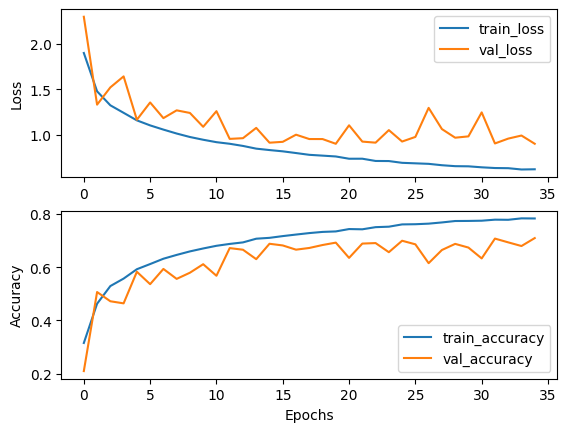

In [51]:
history_plot(training_log_v4)

### Evaluating Model

In [52]:
test_eval = model_v4.evaluate(x_test, y_test)
print(f"Loss: {test_eval[0]} \nAccuracy: {test_eval[1]*100:.2f}%")

313/313 [==============================] - 1s 3ms/step - loss: 0.9336 - accuracy: 0.7027
Loss: 0.9336066246032715 
Accuracy: 70.27%


### Visualising the embeddings

313/313 [==============================] - 1s 2ms/step


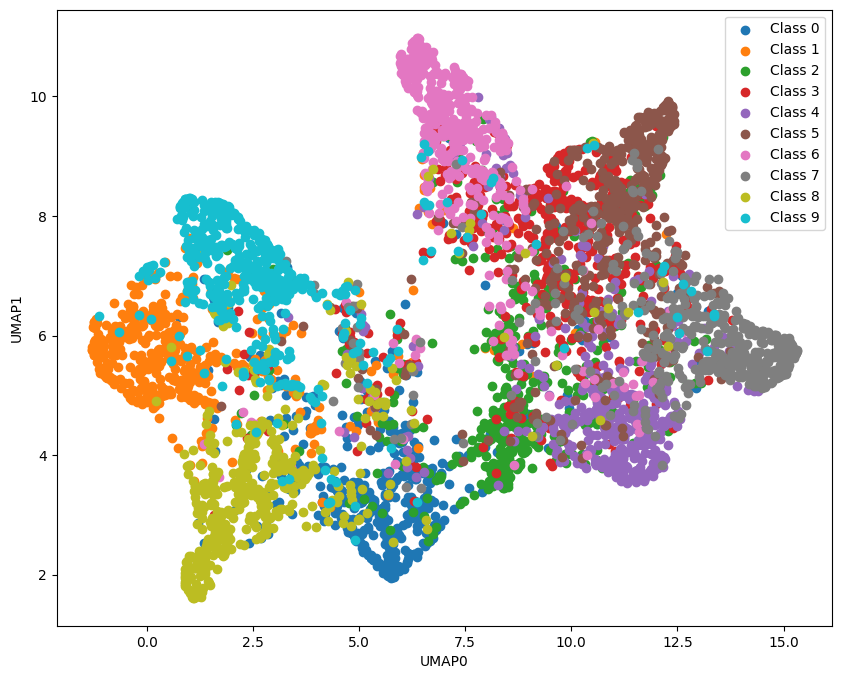

In [53]:
# Gathering the output of the dense layer

dense_v4_model = Model(inputs = model_v4.input, outputs = model_v4.get_layer("p_dense_layer").output)
dense_v4_output = dense_v4_model.predict(x_test)


# Creating visualisation from the given function with 50% sample of test data

visualise_embedding(dense_v4_output, y_test, 0.5)

## Results

* Dimensions are similar to previous model. 10 nodes are in dense layer as z=10 and UMAP mapped these nodes to 2D (UMAP0 and UMAP1)
* Data is well distributed and separated due to LeakyReLU and Batch normalisation accelerated the convergence of loss curve. We still can observe some overfitting.
* Classes are well separated and organised. Still overlapping is present leading to inaccuracies.

## Varient 5: <code><i>model_optimized</i></code>

Updates:
* Updating previous model with NADAM optimizer (lr =0.001).
  * Nesterov-accelerated adaptive moment estimation (Nadam) is an extension of adam optimizer which basically adds Nesterov momentum to the adam optimizer which accelerates and improves the convergence.<br>
  Source: https://medium.com/@nerdjock/deep-learning-course-lesson-7-5-nadam-nesterov-accelerated-adaptive-moment-estimation-efe9050d5b9b
* Added one more layer of dropout after first Convo Layer as the previous model was overfitting.

### Updated Model

In [1]:
# Defining a cnn model function

def cnn_model_optimized(z, input_shape, classes):

    # To create stacking of sequential layers.
    model = Sequential()

    # Conv Layer 1, activation is "LeakyReLU", filters are 32 and kernel size is (4,4)
    model.add(Conv2D(32 , (4,4), input_shape = input_shape, activation = LeakyReLU(alpha = 0.001)))
    model.add(MaxPooling2D((2,2)))
    model.add(BatchNormalization())
    model.add(Dropout (0.5)) # Added Dropout

    # Conv Layer 2, activation is "LeakyReLU", filters are 64 and kernel size is (4,4)
    model.add(Conv2D(64, (4,4), activation = LeakyReLU(alpha = 0.001)))
    model.add(MaxPooling2D((2,2)))
    model.add(BatchNormalization())

    # Conv Layer 3, activation is "LeakyReLU", filters are 128 and kernel size is (4,4)
    model.add(Conv2D(128, (4,4), activation = LeakyReLU(alpha = 0.001)))
    model.add(MaxPooling2D((2,2)))
    model.add(BatchNormalization())

    # Dropout 0.3 fraction of training data to prevent overfitting.
    model.add(Dropout (0.5))
    # Flattening the multi dimensions to single dimension in order to transition from convolutional to dense layer.
    model.add(Flatten())

    # Penultimate dense layer with hyperparameter z as number of neurons.
    model.add(Dense(z, name = "p_dense_layer", activation = LeakyReLU(alpha =0.001)))

    # Final classification head or dense layer with 10 (number of classes) neurons.

    model.add(Dense(classes, activation = "softmax"))

    # Compiling the model with "Nadam" optimizer and loss as categorical cross entropy
    optmz = keras.optimizers.Nadam(learning_rate =0.001) # Nadam optimizer with learning rate as 0.001
    model.compile(loss= "categorical_crossentropy", optimizer = optmz, metrics = ["accuracy"])

    return model

In [ ]:
# Initiallising hyperparameters and training the model instance
z=10
batch = 100
epochs = 35
model_v5 = cnn_model_optimized(z, input_shape, classes)
training_log_v5 = model_v5.fit(x_train, y_train, batch_size = batch, epochs = epochs, validation_split = 0.1)

Epoch 1/35
450/450 [==============================] - 9s 11ms/step - loss: 1.8163 - accuracy: 0.3580 - val_loss: 3.9362 - val_accuracy: 0.1062
Epoch 2/35
450/450 [==============================] - 4s 9ms/step - loss: 1.4124 - accuracy: 0.4923 - val_loss: 1.3448 - val_accuracy: 0.5118
Epoch 3/35
450/450 [==============================] - 4s 9ms/step - loss: 1.2823 - accuracy: 0.5450 - val_loss: 1.2599 - val_accuracy: 0.5530
Epoch 4/35
450/450 [==============================] - 4s 9ms/step - loss: 1.1934 - accuracy: 0.5777 - val_loss: 1.4578 - val_accuracy: 0.4994
Epoch 5/35
450/450 [==============================] - 4s 9ms/step - loss: 1.1278 - accuracy: 0.6016 - val_loss: 1.0401 - val_accuracy: 0.6308
Epoch 6/35
450/450 [==============================] - 4s 9ms/step - loss: 1.0781 - accuracy: 0.6178 - val_loss: 1.0410 - val_accuracy: 0.6302
Epoch 7/35
450/450 [==============================] - 4s 10ms/step - loss: 1.0449 - accuracy: 0.6312 - val_loss: 0.9895 - val_accuracy: 0.6574
Epoc

### Plotting loss and accuracy curve

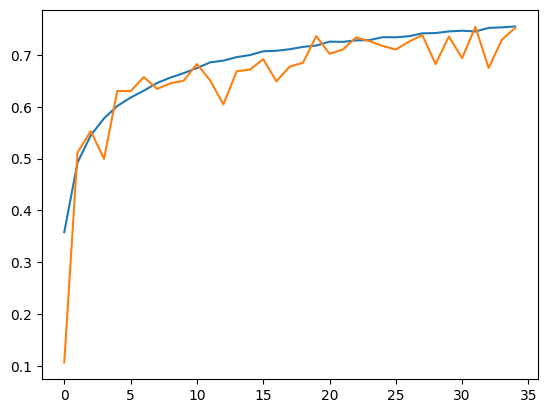

In [ ]:
history_plot(training_log_v5)

### Evaluating Model

In [ ]:
test_eval = model_v5.evaluate(x_test, y_test)
print(f"Loss: {test_eval[0]} \nAccuracy: {test_eval[1]*100:.2f}%")

313/313 [==============================] - 1s 3ms/step - loss: 0.7721 - accuracy: 0.7397
Loss: 0.7720550298690796 
Accuracy: 73.97%


### Visualising the embeddings

313/313 [==============================] - 1s 2ms/step


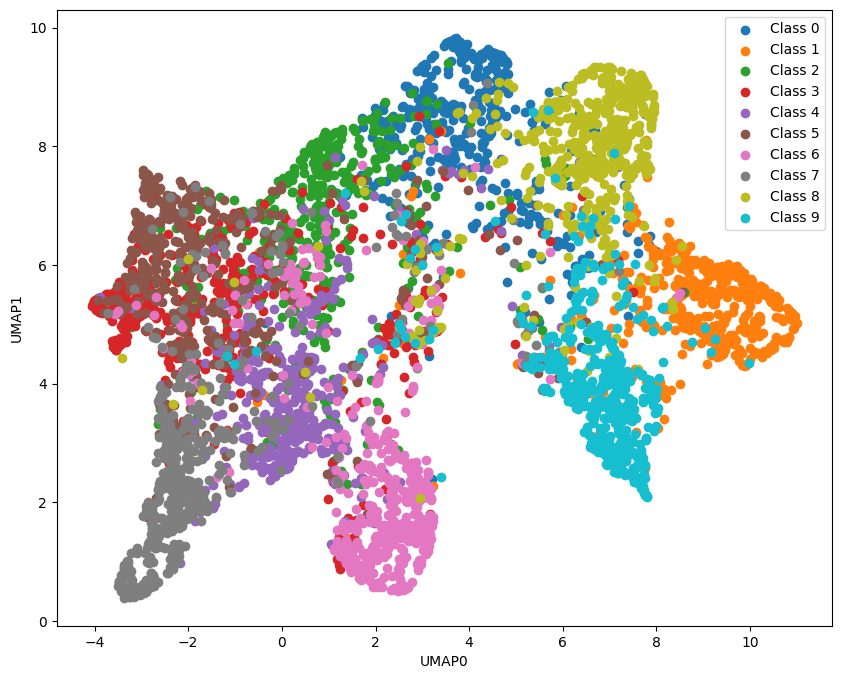

In [ ]:
# Gathering the output of the dense layer

dense_v5_model = Model(inputs = model_v5.input, outputs = model_v5.get_layer("p_dense_layer").output)
dense_v5_output = dense_v5_model.predict(x_test)


# Creating visualisation from the given function with 50% sample of test data

visualise_embedding(dense_v5_output, y_test, 0.5)

## Results
* Dimensions are again similiar to the above mode. 10 nodes of dense layer mapped to 2D using UMAP.
* This model perfomed better than all the varients due to the updates and enhancements done like Nadam optimizer, LeakyReLU, kernel size increment and Batch Normalisation. The data is distributed well in the embedding space. This is a non-linear data distribution as Dense layer creates a non linear embedding.
* We can visulise all the different classes separately as overlapping decreased and accuracy increased compared to all the other varients.

## Task 6: Pretrained Model

###Various Models:

* EfficientNet
  * One of the best architectures present for Image segmentation. With few parameters provide high accuracy and comes in B0-B7 versions with increasing complexities. <br>
  Reference: Petru Potrimba. (Aug 9, 2023). What is EfficientNet? The Ultimate Guide.. Roboflow Blog: https://blog.roboflow.com/what-is-efficientnet/

* MobileNet
  * A good trade-off between speed and accuracy compared to large pretrained models. MobileNet provides good accuracy which might not match with EfficientNet but with low computation cost.<br>
   **Reference**: Generative AI<br>
   **Prompt**: Performance difference betweeen EfficientNet and MobileNet<br>
   **Response**:<br>
  EfficientNet: EfficientNet has achieved state-of-the-art performance on various image classification benchmarks, including ImageNet. By balancing model depth, width, and resolution, EfficientNet achieves high accuracy with fewer parameters compared to other architectures.
  MobileNet: MobileNet is known for its efficiency and compactness, making it suitable for deployment on mobile and embedded devices. While it may not match the performance of larger models like EfficientNet, MobileNet offers a good trade-off between speed, size, and accuracy.

#### For faster computation, used MobileNetV2 for the assignment.


## Importing the models

In [ ]:
from keras.applications import EfficientNetB1, MobileNetV2

### Initialising the pretrained model

In [ ]:
batch = 50
epochs = 35
# Resizing the dataset for MobileNetV2 to get inputshape as (96,96,3)
resizing_layer = Resizing(96,96, input_shape= (32,32,3))

# Creating Instance of the MobileNetV2 pretrained model
pretrained_model_MN = MobileNetV2(include_top=False, # Removing the classification head of the pretrained model to replace with our custom head.
                                  pooling = "max", # Used Global max pooling here rather than adding a layer to the architecture later.
                                  input_shape = (96,96,3)) # Specifying the input shape.

In [ ]:
# Created a dense layer for z = 10 having activation as "relu"
dense_layer = Dense(10, name="p_dense_layer", activation = "relu")

# Creating a custom classification head, having number of classes as the nodes and softmax activation function for classification.
classification_head = Dense(classes, activation = "softmax")

In [ ]:
# Creating a model_new from fine tuning pretrained model by adding various layers to it including classification head.

def model_new(pretrained_model):

    model = Sequential()
    # Resizing the input to create input for pretrained model.
    model.add(resizing_layer)

    # Adding pretrained model layer
    model.add(pretrained_model)

    # Adding a dropout layer to avoid overfitting
    model.add(Dropout(0.5))

    # Adding a dense layer with 1024 nodes as to act as an intermediate between multiple nodes from pretrained model and 10 nodes from next dense_layer.
    # This will avoid information loss by sudden dimension reduction.
    model.add(Dense(1024, activation = "relu"))

    # Adding dense layer with z=10
    model.add(dense_layer)

    # Adding custom classification head.
    model.add(classification_head)

    # Compiling the model using adam optimizer.
    model.compile(loss= "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
    return model


# Freezing layers of pretrained model by updating trainable to false.
for l in pretrained_model_MN.layers:
    l.trainable =False

In [ ]:
# Creating instance of the model created
model_MN = model_new(pretrained_model_MN)

In [ ]:
# Viewing the summary of the model
model_MN.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (None, 96, 96, 3)         0         
                                                                 
 mobilenetv2_1.00_96 (Funct  (None, 1280)              2257984   
 ional)                                                          
                                                                 
 dropout_7 (Dropout)         (None, 1280)              0         
                                                                 
 dense_7 (Dense)             (None, 1024)              1311744   
                                                                 
 p_dense_layer (Dense)       (None, 10)                10250     
                                                                 
 dense_6 (Dense)             (None, 10)                110       
                                                      

In [ ]:
# Training the model
training_log_pt = model_MN.fit(x_train, y_train, batch_size = batch, epochs = epochs, validation_split = 0.1)

Epoch 1/35
900/900 [==============================] - 20s 17ms/step - loss: 2.2947 - accuracy: 0.1073 - val_loss: 2.3030 - val_accuracy: 0.0950
Epoch 2/35
900/900 [==============================] - 14s 16ms/step - loss: 2.2536 - accuracy: 0.1298 - val_loss: 2.1118 - val_accuracy: 0.1814
Epoch 3/35
900/900 [==============================] - 14s 16ms/step - loss: 1.4918 - accuracy: 0.4593 - val_loss: 0.8227 - val_accuracy: 0.7188
Epoch 4/35
900/900 [==============================] - 14s 16ms/step - loss: 0.8688 - accuracy: 0.7030 - val_loss: 0.6962 - val_accuracy: 0.7648
Epoch 5/35
900/900 [==============================] - 15s 16ms/step - loss: 0.7839 - accuracy: 0.7354 - val_loss: 0.6598 - val_accuracy: 0.7796
Epoch 6/35
900/900 [==============================] - 15s 16ms/step - loss: 0.7375 - accuracy: 0.7486 - val_loss: 0.6337 - val_accuracy: 0.7894
Epoch 7/35
900/900 [==============================] - 15s 16ms/step - loss: 0.7070 - accuracy: 0.7580 - val_loss: 0.6310 - val_accuracy:

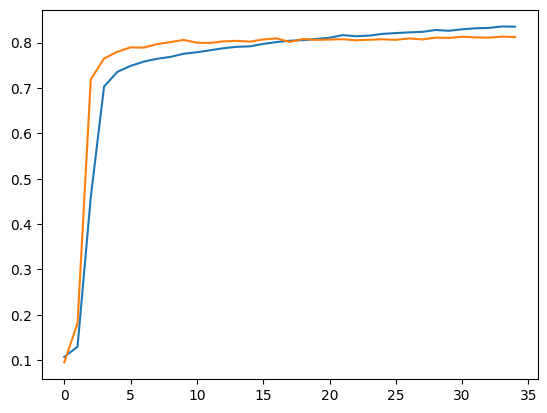

In [ ]:
history_plot(training_log_pt)

### Evaluating Model

In [ ]:
test_eval = model_MN.evaluate(x_test, y_test)
print(f"Loss: {test_eval[0]} \nAccuracy: {test_eval[1]*100:.2f}%")

313/313 [==============================] - 6s 14ms/step - loss: 0.5757 - accuracy: 0.8120
Loss: 0.575712263584137 
Accuracy: 81.20%


### Visualising the embeddings

313/313 [==============================] - 3s 7ms/step


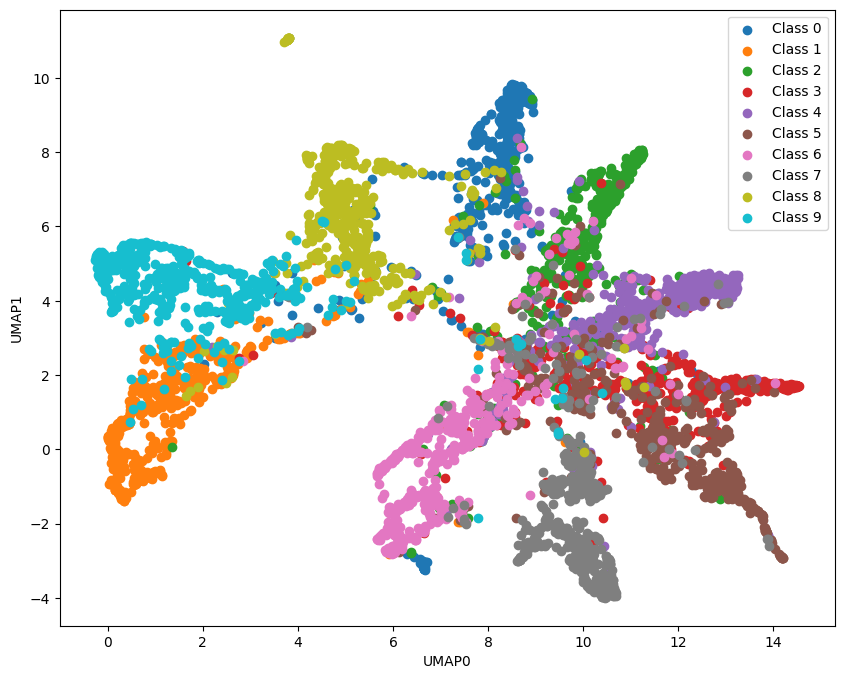

In [ ]:
# Gathering the output of the dense layer

dense_MN_model = Model(inputs = model_MN.input, outputs = model_MN.get_layer("p_dense_layer").output)
dense_MN_output = dense_MN_model.predict(x_test)


# Creating visualisation from the given function with 50% sample of test data

visualise_embedding(dense_MN_output, y_test, 0.5)

## Results

* Dimensions are 10 as z = 10, reduced to 2 using UMAP.
* Data is distributed in clusters and each cluster is well separated. It is a non-linear distribution of data.
* Clusters are well established showing different classes in the embedding space. They are well separated as well with lesser overlapping and more organised.

# Task 7: Comparing the model embeddings


### Updated models

Six models are developed in this assignment with various changes and enhancements. <br>
**Results for task 7 are provided after each model's embedding visualisation.**

Final Conclusions for each model<br>
### <code>model_z2</code>
* Basic model with z=2, low dimension embedding did not perform well in classification as it lead to information loss. Hence, it showed poor accuracy.
<br>

### <code>model_z10</code>
* This model is enhanced by updating the z value to 10. As the dimensions are increased, the embedding performed better than z=2. The embedding is distributed with separate clusters reprensenting classes. Accuracy is better than previous model but still some overlapping is present.
<br>

### <code>model_k4</code>
* Previous model is updated with kernel size and filters are increased for the last Convolutional layer. Both are used to capture broader pattern in the dataset. Hence, we can see better organised clusters in the embedding visualisation. There was overfitting, as now the model is trying to capture complex patterns and fitting too close to training data.
<br>

### <code>model_k4_normal</code>
* To avoid overfitting, we introduced Batch Normalisation and also increased the dropout value. Batch normalisation not only avoids overfitting but also accelerated the convergence, as observed in the loss curve.
<br>

### <code>model_optimized</code>
* We used Nadam optimizer which used Nesterov momentum to not only accelerates the convergence but also converges better than adam. Results shows that this model performed better than all the previous models. The data is well clustered and all the clusters are better separated.
<br>

### <code>model_new</code>
* Adapded the MobileNetV2, removed its classification head and freezed its layers. Created a new model with this pretrained model by adding custom classification head and some other layers for enhancement. We can see that the model performs better than any of the previous model. The clusters are not only organised closely but also are well separated. Model performs good with lesser overlappig and high accuracy.

<hr>